<a href="https://colab.research.google.com/github/pasou-vestas/mooc-machine-learning-weather-climate/blob/main/openDays_workshop3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Layout optimization

Let's now optimize our previous layout.

**Install TOPFARM if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

Loading Python dependencies.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString

Loading PyWake dependencies.

In [ ]:
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_turbines.power_ct_functions import CubePowerSimpleCt
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.utils.gradients import autograd
from py_wake import BastankhahGaussian
import py_wake

Loading TOPFARM dependencies.

In [ ]:
import topfarm
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import TurbineTypePlotComponent
from topfarm import SpacingConstraint, XYBoundaryConstraint
from topfarm.constraint_components.boundary import TurbineSpecificBoundaryComp
from topfarm.easy_drivers import EasyRandomSearchDriver, EasyScipyOptimizeDriver
from topfarm.drivers.random_search_driver import randomize_turbine_type, RandomizeTurbineTypeAndPosition
from topfarm.constraint_components.boundary import InclusionZone, ExclusionZone

Initializing our custom wind turbine

In [ ]:
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import numpy as np

wsV80 = np.arange(0, 36, 1)
powerV80 = np.array([   0,    0,    0,    0,   66,  154,  282,  460,  696,  996, 1341,
                     1661, 1866, 1958, 1988, 1997, 1999, 2000, 2000, 2000, 2000, 2000,
                     2000, 2000, 2000, 2000,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0])
ctV80 = np.array([0.   , 0.   , 0.   , 0.   , 0.818, 0.806, 0.804, 0.805, 0.806,
                  0.807, 0.793, 0.739, 0.709, 0.409, 0.314, 0.249, 0.202, 0.167,
                  0.14 , 0.119, 0.102, 0.088, 0.077, 0.067, 0.06 , 0.053, 0.   ,
                  0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.])
rhoV80 = 1.225
diameterV80 = 80


my_wt = WindTurbine(name='MyWT',
                    diameter=diameterV80,
                    hub_height=100,
                    rho = rhoV80,
                    powerCtFunction=PowerCtTabular(wsV80,powerV80,'kW',ctV80))

In [ ]:
# Defining the site

from py_wake.site import UniformWeibullSite

# Unidirectional wind rose
p_wd = [0.78] + [0.02]*11

#specifying the necessary parameters for the UniformWeibullSite object
site = UniformWeibullSite(p_wd = p_wd,                         # sector frequencies
                          a = [9]*12,       # Weibull scale parameter
                          k = [2.4]*12,     # Weibull shape parameter
                          ti = 0.1          # turbulence intensity, optional
                         )

site.plot_wd_distribution()

In [ ]:
from py_wake import NOJ

# wind farm model
wfm = NOJ(site, my_wt)

We also set up the number of wind turbines as well as their initial positions. The turbine types are created randomly and the turbine coordinates in x and y are limited.

In [ ]:
# The coordinates from the pywake notebook:

# number of turbines in each direction:
n_x = 5
n_y = 3

rotor_diameter = diameterV80
dist_x = 2 * rotor_diameter
dist_y = 2 * rotor_diameter

# This defines the turbine positions
wt_x, wt_y = np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y)
wt_x = wt_x.flatten()
wt_y = wt_y.flatten()



In [ ]:
# geometries for boundary constraints 

x_min, x_max = wt_x.min()-50, wt_x.max()+50 # limits for x
y_min, y_max = wt_y.min()-50, wt_y.max()+50 # limits for y

# wind farm main boundaries
x1 = [x_min, x_max, x_max, x_min]
y1 = [y_min, y_min, y_max, y_max]
b1 = np.transpose((x1, y1))
ie1 = 1
d1 = None
t1 = 'polygon'

Then we group all geometries in a boundary component.

In [ ]:
# group all geometries in a boundary component 
zones = [InclusionZone(b1)]

xybound = XYBoundaryConstraint(zones, boundary_type='multi_polygon')

The objective function and its gradients is set up in addition to the `CostModelComponent`.

In [ ]:
# AEP function and gradients (with autograd)
def aep_func(x, y, **kwargs):
    simres = wfm(x, y, **kwargs)
    return simres.aep(normalize_probabilities=True).values.sum()

def daep_func(x, y, **kwargs):
    grad = wfm.aep_gradients(gradient_method=autograd, wrt_arg=['x', 'y'])(x, y)
    return grad

# AEP cost component
aep_comp = CostModelComponent(input_keys=[('x', wt_x), ('y', wt_y)],
                              n_wt=n_wt,
                              cost_function=aep_func,
                              cost_gradient_function=daep_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('AEP', 0)],
                              output_unit='GWh')

Lastly, the `TopFarmProblem` is set up where both the layout and the turbine types are optimized simultaneously.

In [ ]:
problem = TopFarmProblem(design_vars={'x': wt_x,
                                      'y': wt_y
                                      },
                          cost_comp=aep_comp,
                          constraints=[xybound, SpacingConstraint(2*rotor_diameter)],
                          driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=500),
                          expected_cost=1e-2
                          )

With the optimization problem fully defined, let's finally optimize the layout with a gradient-based optimization method:

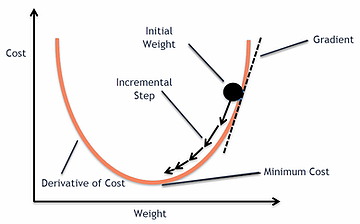

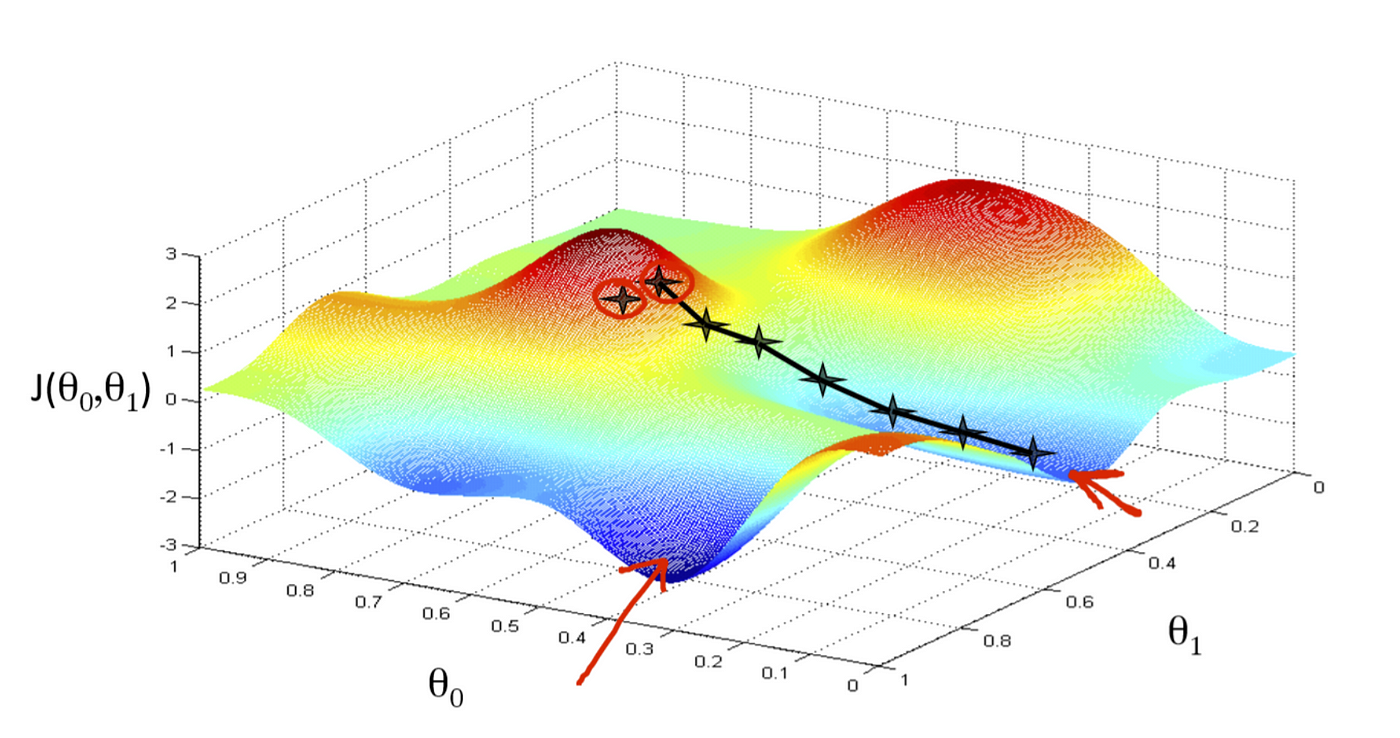

In [ ]:
cost, state, recorder = problem.optimize()

In [ ]:
# Saving an animation of the optimization
recorder.animate_turbineXY(filename='animation.gif')

Now lets inspect if the result seems to make sense. We defined a unidirectional wind rose with exactly this purpose. 

In [ ]:
# See the final results

sim_res_original = wfm(wt_x, wt_y)
original_aep = sim_res_original.aep().sum().values.round(2)
print(f"******* Original layout - {original_aep} GWh *******")
sim_res_original.flow_map(wd=[0], ws=[10]).plot_wake_map()
plt.show()

sim_res_opt = wfm(state['x'], state['y'])
opt_aep = sim_res_opt.aep().sum().values.round(2)
gain = ((opt_aep-original_aep)/original_aep)*100
print(f"******* Optimized layout - {opt_aep} GWh (+{gain.round(1)}%) *******")
sim_res_opt.flow_map(wd=[0], ws=[10]).plot_wake_map()
plt.show()

###Final exercise: 
- 1 - Now change the wind rose to match the one from the previous notebook and see how the optimal layout changes.
- 2 - How does the gain in AEP compares between the 2 cases?
- 3 - Try with as many turbines as you want (if the notebook crashes we reached the limit with the amount of RAM provided by google colab).


---

